# CIFAR10 Transfer Learning based Classifier

This notebook outlines the steps to build a classifier to leverage concepts of Transfer Learning by utilizing a pretrained Deep-CNN. 
Particularly in this case based on densenet

In [ ]:
import os
path="/content/drive/MyDrive/1111"
os.chdir(path)
os.listdir(path)

[]

In [ ]:
!pip uninstall scipy
!pip install scipy==1.2.2

Found existing installation: scipy 1.4.1
Uninstalling scipy-1.4.1:
  Would remove:
    /usr/local/lib/python3.7/dist-packages/scipy-1.4.1.dist-info/*
    /usr/local/lib/python3.7/dist-packages/scipy/*
Proceed (y/n)? y
  Successfully uninstalled scipy-1.4.1
y
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 24.8 MB 1.4 MB/s 
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
albumentations 0.1.12 requires imgaug<0.2.7,>=0.2.5, but you have imgaug 0.2.9 which is incompatible.


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Pandas and Numpy for data structures and util fucntions
import scipy as sp
import numpy as np
import pandas as pd
from numpy.random import rand
pd.options.display.max_colwidth = 600

# Scikit Imports
from sklearn import preprocessing
from sklearn.metrics import roc_curve, auc, precision_recall_curve
from sklearn.model_selection import train_test_split

# import cnn_utils as utils
# from model_evaluation_utils import get_metrics

# Matplot Imports
import matplotlib.pyplot as plt
params = {'legend.fontsize': 'x-large',
          'figure.figsize': (15, 5),
          'axes.labelsize': 'x-large',
          'axes.titlesize':'x-large',
          'xtick.labelsize':'x-large',
          'ytick.labelsize':'x-large'}

plt.rcParams.update(params)
%matplotlib inline

# pandas display data frames as tables
from IPython.display import display, HTML

import warnings
warnings.filterwarnings('ignore')

In [ ]:
import tensorflow as tf
from keras import callbacks
from keras import optimizers
from keras.datasets import cifar10
from keras.models import Model
from keras.applications import vgg16 as vgg
from keras.applications import resnet
from keras.applications import densenet

from keras.layers import Dropout, Flatten, Dense, GlobalAveragePooling2D,BatchNormalization
from keras.preprocessing.image import ImageDataGenerator
from keras.utils import np_utils

## Load and Prepare DataSet

In [ ]:
l

Split training dataset in train and validation sets

In [ ]:

from tensorflow.keras.utils import to_categorical

def load_images():
    (train_images, train_labels), (test_images, test_labels) = cifar10.load_data()

    train_images = train_images.astype(np.float32)
    test_images = test_images.astype(np.float32)


    train_labels = to_categorical(train_labels, 10)
    test_labels = to_categorical(test_labels, 10)

    # train_dataset = tf.data.Dataset.from_tensor_slices((train_images, train_labels)).shuffle(
    #     buffer_size=10000).batch(batch_size)
    # test_dataset = tf.data.Dataset.from_tensor_slices((test_images, test_labels)).batch(batch_size)

    return train_images, train_labels, test_images, test_labels
X_train, y_train, X_test, y_test = load_images()

Transform target variable/labels into one hot encoded form

### Preprocessing

Since we are about to use dense net as a feature extractor, the minimum size of an image it takes is 48x48.
We utilize ```scipy`` to resize images to required dimensions

In [ ]:
X_train = np.array([sp.misc.imresize(x, 
                                     (64, 64)) for x in X_train])

X_test = np.array([sp.misc.imresize(x, 
                                    (64, 64)) for x in X_test])

## Prepare the Model

* Load VGG16 without the top classification layer
* Prepare a custom classifier
* Stack both models on top of each other

In [ ]:
base_model = densenet.DenseNet169(weights='imagenet', 
                       include_top=False, 
                       input_shape=(64, 64, 3))
base_model.summary()

Model: "densenet169"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 64, 64, 3)]  0           []                               
                                                                                                  
 zero_padding2d_2 (ZeroPadding2  (None, 70, 70, 3)   0           ['input_2[0][0]']                
 D)                                                                                               
                                                                                                  
 conv1/conv (Conv2D)            (None, 32, 32, 64)   9408        ['zero_padding2d_2[0][0]']       
                                                                                                  
 conv1/bn (BatchNormalization)  (None, 32, 32, 64)   256         ['conv1/conv[0][0]']   

In [ ]:
# Extract the last layer from third block of vgg16 model
last = base_model.get_layer('relu').output

In [ ]:
# Add classification layers on top of it
x = GlobalAveragePooling2D()(last)
x= BatchNormalization()(x)
x = Dense(1024, activation='relu')(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.5)(x)
pred = Dense(NUM_CLASSES, activation='softmax')(x)
model = Model(base_model.input, pred)

Since our objective is to only train the custom classifier, we freeze the layers of VGG16

In [ ]:
for layer in base_model.layers:
     layer.trainable = False

In [ ]:
model.compile(loss='binary_crossentropy',
              optimizer=tf.keras.optimizers.Adam(lr=LEARNING_RATE),
              metrics=['accuracy'])

## Data Augmentation

To help model generalize and overcome the limitations of a small dataset, we prepare augmented datasets using 
```keras ``` utilities

In [ ]:
# prepare data augmentation configuration
datagen_train = ImageDataGenerator(
    rescale=1. / 255,
        featurewise_center=False,
        samplewise_center=False,
        featurewise_std_normalization=False,
        samplewise_std_normalization=False,
        zca_whitening=False,
        rotation_range=0,
        width_shift_range=0.125,
        height_shift_range=0.125,
        horizontal_flip=True,
        vertical_flip=False)
datagen_train.fit(X_train)
train_generator = datagen_train.flow(X_train,
                                 y_train,
                                 batch_size=BATCH_SIZE)

In [ ]:
test_datagen = ImageDataGenerator(rescale=1. / 255,
    horizontal_flip=False)

test_datagen.fit(X_test)
test_generator = test_datagen.flow(X_test,
                                 y_test,
                                 batch_size=BATCH_SIZE)

## Train the Model

In [ ]:
train_steps_per_epoch = X_train.shape[0] // BATCH_SIZE
val_steps_per_epoch = X_test.shape[0] // BATCH_SIZE

history = model.fit_generator(train_generator,
                              steps_per_epoch=train_steps_per_epoch,
                              validation_data=test_generator,
                              validation_steps=val_steps_per_epoch,
                              epochs=50,
                              verbose=1)

226/781 [=======>......................] - ETA: 1:11 - loss: 0.0502 - accuracy: 0.9085

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py", line 2882, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-23-da54c755fd67>", line 9, in <module>
    verbose=1)
  File "/usr/local/lib/python3.7/dist-packages/keras/engine/training.py", line 2223, in fit_generator
    initial_epoch=initial_epoch)
  File "/usr/local/lib/python3.7/dist-packages/keras/utils/traceback_utils.py", line 64, in error_handler
    return fn(*args, **kwargs)
  File "/usr/local/lib/python3.7/dist-packages/keras/engine/training.py", line 1384, in fit
    tmp_logs = self.train_function(iterator)
  File "/usr/local/lib/python3.7/dist-packages/tensorflow/python/util/traceback_utils.py", line 150, in error_handler
    return fn(*args, **kwargs)
  File "/usr/local/lib/python3.7/dist-packages/tensorflow/python/eager/def_function.py", line 915, in __call__
    result = self._call(*args, **kwds)
  File "/usr/local/li

KeyboardInterrupt: ignored

## Analyze Model Performance

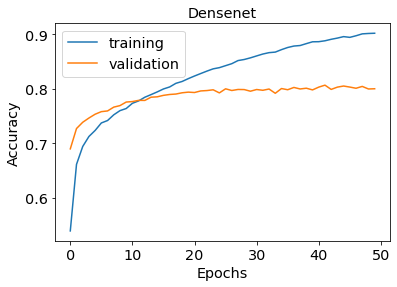

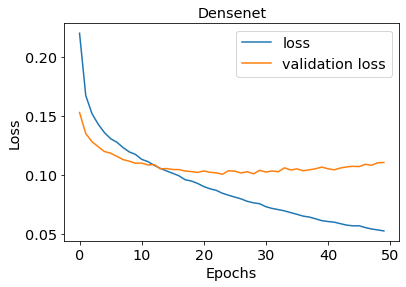

In [ ]:
plt.plot(history.history["accuracy"], label="training")
plt.plot(history.history["val_accuracy"], label="validation")
plt.title("Densenet")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.show()
plt.plot(history.history["loss"], label="loss")
plt.plot(history.history["val_loss"], label="validation loss")
plt.title("Densenet")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

In [ ]:
# model.save("transfer.h5")
# predictions = model.predict(X_val/255.)

(10000,)
[3 8 8 ... 5 1 7]
(10000,)
Confusion Matrix
 [[872  18  14   7   9   3   7   8  39  23]
 [ 11 876   1   6   3   4   6   0   9  84]
 [ 46   0 713  33  63  24  82  32   4   3]
 [ 14  16  29 625  30 159  75  30   7  15]
 [ 13   2  46  43 733  32  67  58   4   2]
 [  7   5  20 129  21 740  35  38   4   1]
 [  5   4  21  36  18  18 887   6   1   4]
 [ 16   5  14  25  50  42   8 835   2   3]
 [ 54  29   5   5   8   0   2   3 875  19]
 [ 20  84   1   6   0   3   5   4  13 864]]


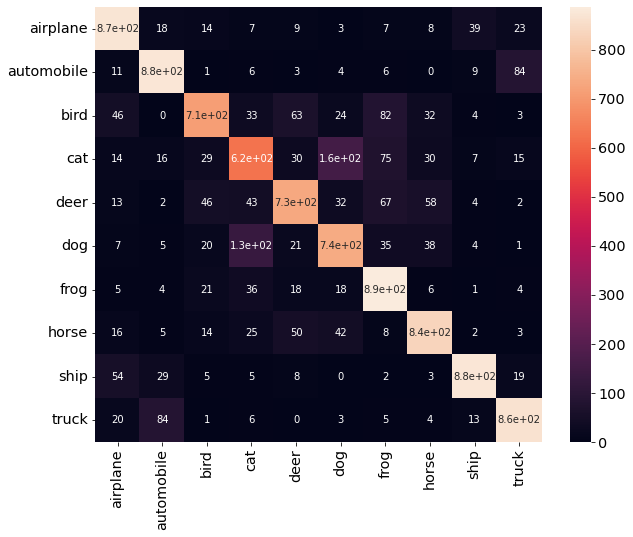

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sb
test_predict = model.predict(X_test/255)
y_test_labels = np.argmax(test_predict, axis=1)
y_test1 = np.argmax(y_test, axis=1)
print(y_test1.shape)
print(y_test1)
print(y_test_labels.shape)
cm = confusion_matrix(y_test1, y_test_labels)
class_labels = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
print("Confusion Matrix\n", cm)
df_c_matrix = pd.DataFrame(cm, index=[clss for clss in class_labels], columns=[clss for clss in class_labels])
plt.figure(figsize=(10, 8))
sb.heatmap(df_c_matrix, annot=True)
plt.show()

## Visualize Predictions

In [ ]:
label_dict = {0:'airplane',
             1:'automobile',
             2:'bird',
             3:'cat',
             4:'deer',
             5:'dog',
             6:'frog',
             7:'horse',
             8:'ship',
             9:'truck'}

RuntimeError: ignored

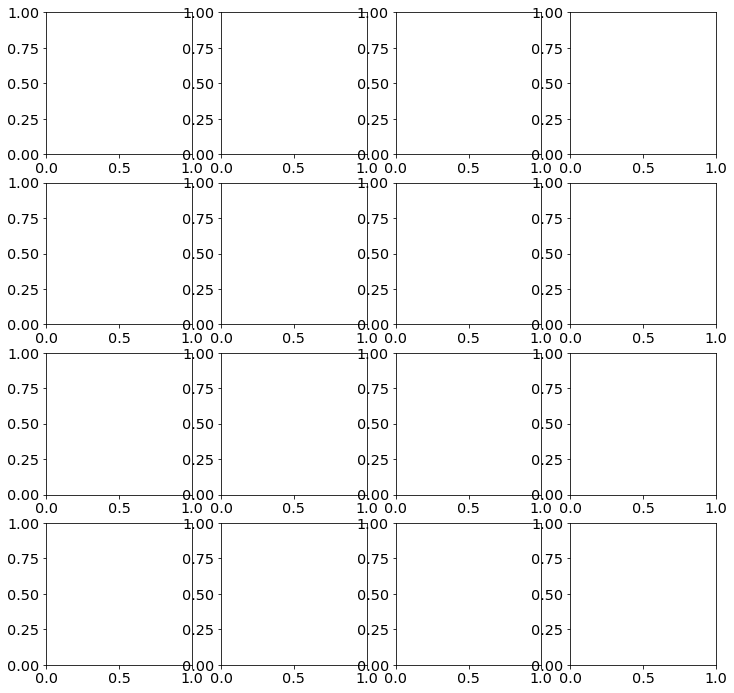

In [ ]:
utils.plot_predictions(model=model,dataset=X_test/255.,
                       dataset_labels=Y_test,
                       label_dict=label_dict,
                       batch_size=16,
                       grid_height=4,
                       grid_width=4)

fine-turning

In [ ]:
for layer in base_model.layers:
     layer.trainable = True

In [ ]:
# model = tf.keras.models.load_model('/content/drive/MyDrive/Transfer-Learning-with-CIFAR10-master/transfer.h5')
model.compile(loss='binary_crossentropy',
              optimizer=tf.keras.optimizers.Adam(lr=1e-5),
              metrics=['accuracy'])


In [ ]:
BATCH_SIZE = 64

train_steps_per_epoch = X_train.shape[0] // BATCH_SIZE
test_steps_per_epoch = X_test.shape[0] // BATCH_SIZE

history = model.fit_generator(train_generator,
                              steps_per_epoch=train_steps_per_epoch,
                              validation_data=test_generator,
                              validation_steps=val_steps_per_epoch,
                              epochs=100,
                              verbose=1)

Epoch 1/100
781/781 [==============================] - 120s 128ms/step - loss: 0.1144 - accuracy: 0.7824 - val_loss: 0.0967 - val_accuracy: 0.8210
Epoch 2/100
781/781 [==============================] - 93s 119ms/step - loss: 0.0799 - accuracy: 0.8484 - val_loss: 0.0799 - val_accuracy: 0.8522
Epoch 3/100
781/781 [==============================] - 93s 119ms/step - loss: 0.0671 - accuracy: 0.8757 - val_loss: 0.0717 - val_accuracy: 0.8680
Epoch 4/100
781/781 [==============================] - 96s 123ms/step - loss: 0.0575 - accuracy: 0.8918 - val_loss: 0.0666 - val_accuracy: 0.8769
Epoch 5/100
781/781 [==============================] - 96s 122ms/step - loss: 0.0512 - accuracy: 0.9047 - val_loss: 0.0639 - val_accuracy: 0.8857
Epoch 6/100
781/781 [==============================] - 95s 121ms/step - loss: 0.0452 - accuracy: 0.9167 - val_loss: 0.0591 - val_accuracy: 0.8959
Epoch 7/100
781/781 [==============================] - 95s 122ms/step - loss: 0.0407 - accuracy: 0.9263 - val_loss: 0.0564 

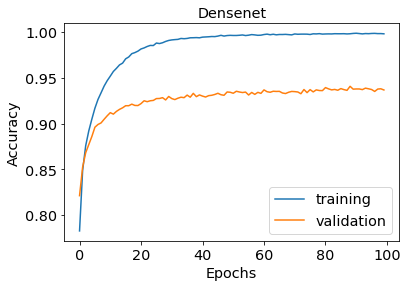

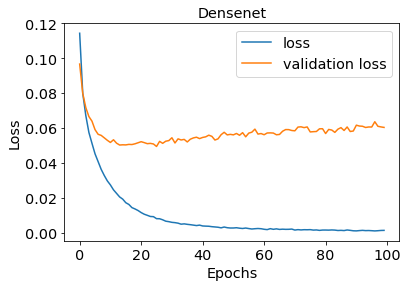

(10000,)
[3 8 8 ... 5 1 7]
(10000,)
Confusion Matrix
 [[953   4   9   3   4   0   2   1  17   7]
 [  5 975   0   0   0   1   1   1   1  16]
 [ 11   0 926   8  17   8  16  13   1   0]
 [  8   2  12 856  19  65  20   9   2   7]
 [  5   1  13  15 926   5  18  16   0   1]
 [  2   0   6  75  12 883   5  17   0   0]
 [  6   0   9   6   1   2 975   0   0   1]
 [  3   0   8   7  13  16   2 948   0   3]
 [ 15   6   3   0   0   0   0   1 968   7]
 [  6  33   1   0   0   0   0   0   3 957]]


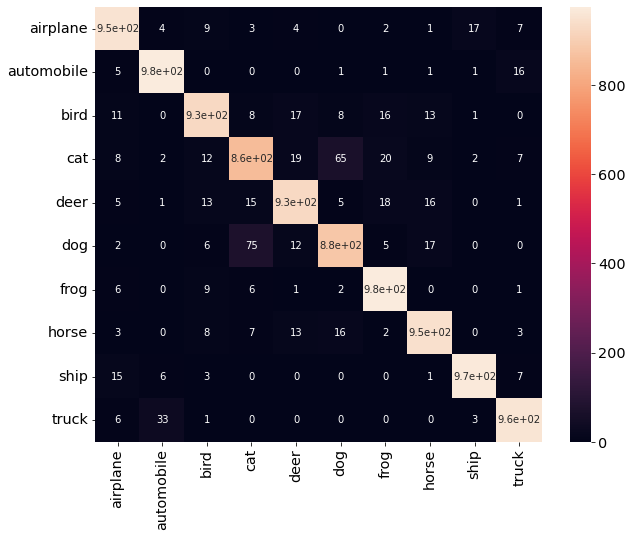

In [ ]:
plt.plot(history.history["accuracy"], label="training")
plt.plot(history.history["val_accuracy"], label="validation")
plt.title("Densenet")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.show()
plt.plot(history.history["loss"], label="loss")
plt.plot(history.history["val_loss"], label="validation loss")
plt.title("Densenet")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()
from sklearn.metrics import confusion_matrix
import seaborn as sb
test_predict = model.predict(X_test/255)
np.save('test_predict.npy',test_predict)
y_test_labels = np.argmax(test_predict, axis=1)
y_test1 = np.argmax(y_test, axis=1)
print(y_test1.shape)
print(y_test1)
print(y_test_labels.shape)
cm = confusion_matrix(y_test1, y_test_labels)
class_labels = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
print("Confusion Matrix\n", cm)
df_c_matrix = pd.DataFrame(cm, index=[clss for clss in class_labels], columns=[clss for clss in class_labels])
plt.figure(figsize=(10, 8))
sb.heatmap(df_c_matrix, annot=True)
plt.show()

In [ ]:
import os
path="/content/drive/MyDrive/1111"
os.chdir(path)
os.listdir(path)


In [ ]:
# test_predict2 = model.predict(X_test/255)
np.save('test_predict.npy',test_predict)
model.save('dense.h5')